In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math
import random
from keras.models import Sequential,Model
from keras.layers import TimeDistributed,Dense,Activation,Layer,Input,Average,Concatenate,Flatten,Lambda
from keras.optimizers import Adam
import pylab as pl
from IPython import display
import numpy as np
import csv
import data_format
from sys import argv

In [2]:
def csv_to_array(csv_file_name):
    data = []
    flag = True
    with open(csv_file_name, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if(flag):
                flag = False
                continue
            data.append(row)
    
    data = np.array(data)

In [9]:
#TODO: modified here
train_side = argv[0] 
d_N = 1
n_max=1 # maximum number of observations that can be used during the training process
a,b,c,d = data_format.data_per_trajectory('./carry_data/train1', True)
train_joints = np.array(a)[:, :8, :] #for left arm
if train_side == "right":
    train_joints = np.array(a)[:,8:,:]
train_n = np.array(b)
train_t = np.array(c)  
train_p = np.array(d)


c:\Users\dmtya\Cappuccino-Preparing-Robot-Baxter\data_format.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), max_size


In [12]:
train_n

array([3866, 3866])

In [15]:
train_p

array([[0.57734376, 0.80859375],
       [0.57734376, 0.80859375]], dtype=float32)

In [ ]:
plt.plot(train_joints[0,1,:])

(2, 8, 3866)

In [7]:
train_joints[:, :8, :]

array([[[-2.6844663e-03, -5.4801464e-01,  3.0679617e-03, ...,
          9.5623985e+01,  8.8702440e-01, -4.6019424e-02],
        [-1.3729128e-01,  9.3035936e-01, -1.1811652e-01, ...,
         -5.4686415e-01,  3.0679617e-03,  7.5318456e-01],
        [-3.4514568e-03,  1.2547963e+00,  2.3009712e-03, ...,
          6.9757777e-01, -1.1428157e-01, -5.0621367e-01],
        ...,
        [ 2.6844663e-03,  7.5280106e-01, -3.0679617e-03, ...,
         -1.0277671e-01, -3.3709228e-01,  1.3391652e+00],
        [ 3.9346609e-01, -8.4829140e-01,  1.2156798e-01, ...,
          7.5280106e-01, -3.0679617e-03,  1.2555633e+00],
        [ 1.9174760e-03,  9.5623985e+01,  1.4599662e+00, ...,
         -9.8519915e-01,  1.3230585e-01,  9.5454544e+01]],

       [[-2.6844663e-03, -5.4763114e-01,  3.0679617e-03, ...,
          9.5623985e+01,  9.1310209e-01,  5.2155346e-02],
        [-1.9481556e-01,  7.7235931e-01,  7.6699042e-04, ...,
         -5.4763114e-01,  3.0679617e-03,  7.5395155e-01],
        [-3.4514568e-03, 

In [8]:
def get_train_sample():
    observation = np.zeros((1,n_max,11))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,3)) # t, ob_p, w_p  
    gamma = random.randint(0,d_N-1)
    ob_p = train_p[gamma,0]
    w_p = train_p[gamma,1]
    obs_n = random.randint(1,n_max)
    
    perm = np.random.permutation(train_n[gamma])
    
    for i in range(obs_n):
        observation[0,i] = [train_t[gamma,perm[i]],
                            ob_p, # 0,1,2 -> 1/3,2/3,1
                            w_p, # 0,1,2,3 -> 1/4,2/4,3/4,1
                            train_joints[gamma,0,perm[i]],
                            train_joints[gamma,1,perm[i]],
                            train_joints[gamma,2,perm[i]],
                            train_joints[gamma,3,perm[i]],
                            train_joints[gamma,4,perm[i]],
                            train_joints[gamma,5,perm[i]],
                            train_joints[gamma,6,perm[i]],
                            train_joints[gamma,7,perm[i]]
                           ]
        observation_flag[0,0,i] = 1./obs_n
    target[0,0] = [train_t[gamma,perm[obs_n]], ob_p, w_p]
    return [observation,observation_flag,target], \
            [[[[train_joints[gamma,0,perm[obs_n]],
                train_joints[gamma,1,perm[obs_n]],
                train_joints[gamma,2,perm[obs_n]],
                train_joints[gamma,3,perm[obs_n]],
                train_joints[gamma,4,perm[obs_n]],
                train_joints[gamma,5,perm[obs_n]],
                train_joints[gamma,6,perm[obs_n]],
                train_joints[gamma,7,perm[obs_n]]
                ]]]],gamma

In [9]:
def plt_predictions(gamma=1): 
    ob_p=train_p[gamma,0]
    w_p=train_p[gamma,1]
    prediction = np.zeros((8,train_n[gamma]))
    prediction_std = np.zeros((8,train_n[gamma])) #TODO: 6?
    observation = np.zeros((1,n_max,11))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,3))
    observation[0,0] = [0,ob_p,w_p,
                        train_joints[gamma,0,0],
                        train_joints[gamma,1,0],
                        train_joints[gamma,2,0],
                        train_joints[gamma,3,0],
                        train_joints[gamma,4,0],
                        train_joints[gamma,5,0],
                        train_joints[gamma,6,0],
                        train_joints[gamma,7,0]]
    observation_flag[0,0,0] = 1.
    joint_names = ['a','b','c','d','e','f','g','h']        
    for i in range(train_n[gamma]):
        target[0,0] = [train_t[gamma,i],ob_p,w_p]
        p = model.predict([observation,observation_flag,target])[0][0]
        prediction[:,i] = p[:8]
        for j in range(8):
            prediction_std[j,i] = math.log(1+math.exp(p[j]))#TODO: dont understand here. did I do right?
    for joint in range(8):
        fig = plt.figure(figsize=(5,5))
        plt.title(joint_names[joint])
        # if joint == 4:
        #     plt.ylim(-1.35,-1.75)
        for i in range(d_N):
            plt.plot(range(train_n[i]),train_joints[i,joint,:train_n[i]], color='green')
        plt.plot(range(train_n[gamma]),prediction[joint,:train_n[gamma]],color='red')
        plt.errorbar(range(train_n[gamma]),prediction[joint,:train_n[gamma]],yerr=prediction_std[2,:train_n[gamma]],color = 'red',alpha=0.1)
        plt.show()

In [4]:
def custom_loss(y_true, y_pred):
    mean, log_sigma = tf.split(y_pred, 2, axis=-1)
    y_target, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_target))
    return loss

In [11]:
observation_layer = Input(shape=(n_max,11))
observation_flag_layer=Input(shape=(1,n_max)) 
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128))(observation_encoded)
matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,128))
representation=matmul_layer([observation_flag_layer,observation_encoded])
target_layer = Input(shape=(1,3))
query_net_input = Concatenate(axis=2)([representation, target_layer])
query = Dense(128, activation='relu')(query_net_input)
query = Dense(128, activation='relu')(query)
query = Dense(128, activation='relu')(query)
query = Dense(128, activation='relu')(query)
output_layer = Dense(8)(query)
model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 11)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 1, 128)      1536        ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 1, 128)      16512       ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

c:\Users\dmtya\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<Figure size 640x480 with 0 Axes>

step: 0
loss: 2.204674243927002


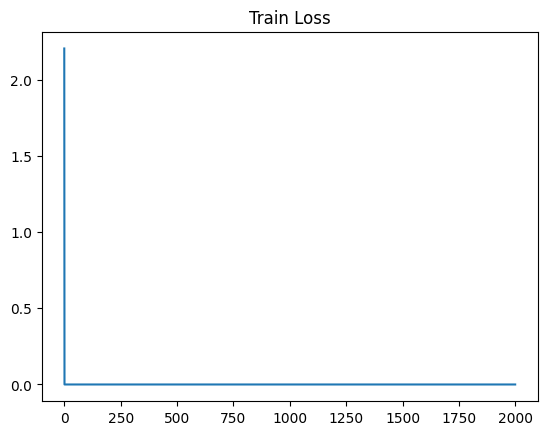

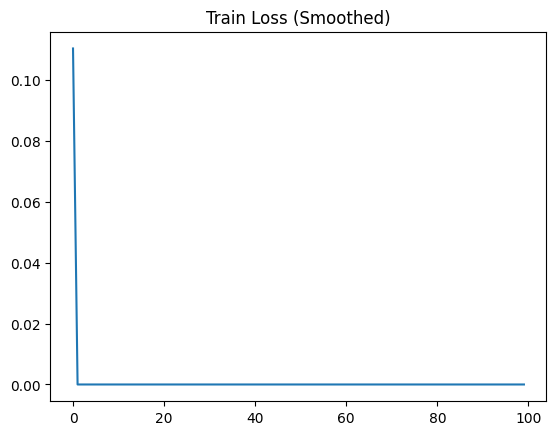

1/1 [==============================] - 0s 86ms/step


KeyboardInterrupt: 

In [12]:
#TODO: I MODIFIED HERE
import gc
train_loss = np.zeros(2000)
max_iterations=10000
save_model_name = "task_parametrization_left.h5"
if train_side == "right":
    save_model_name = "task_parametrization_right.h5"

for step in range(max_iterations):
    inp,out,gamma = get_train_sample()
    out = np.array(out)
    data = model.fit(inp,out,batch_size=1,verbose=0)

    if step % 1000 == 0:
        train_loss[step//1000] = data.history['loss'][0]
        tf.keras.backend.clear_session()
        gc.collect()
    if step % 10000 == 0:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print( 'step:', step)
        print( 'loss:', data.history['loss'][0])
        plt.title('Train Loss')
        plt.plot(range(2000),train_loss)
        plt.show()
        mean_loss = np.zeros((100))
        for i in range(100):
            mean_loss[i] = np.mean(train_loss[i*20:(i+1)*20])
        fig = plt.figure()
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(100),mean_loss)
        plt.show()
        model.save(save_model_name)
        plt_predictions(0)

In [21]:
train_joints[0,:,0]

array([-0.00268447, -0.13729128, -0.00345146,  0.12923788,  0.9786797 ,
        0.00268447,  0.3934661 ,  0.00191748], dtype=float32)

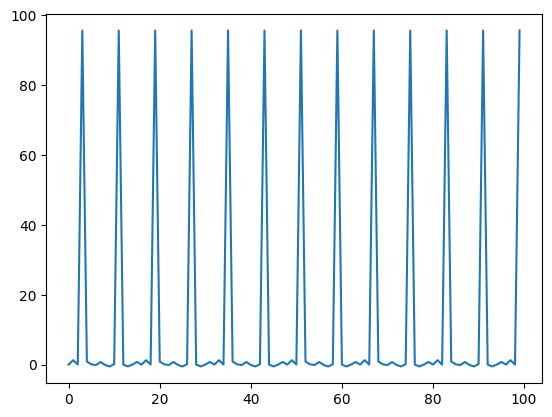

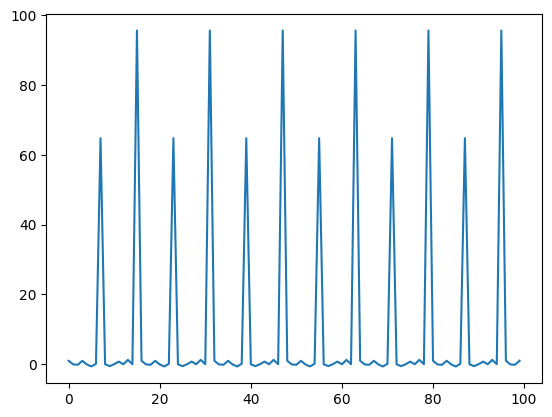

In [18]:
plt.plot(train_joints[0,2,:100])
plt.figure()
plt.plot(train_joints[0,4,:100])



In [ ]:
model.save("task_parametrization.h5")

In [7]:
import keras.losses
keras.losses.custom_loss = custom_loss
from keras.models import load_model

model = load_model('./trained_models/task_parametrization_left.h5', custom_objects={ 'tf':tf })

In [8]:
train_t[0]

NameError: name 'train_t' is not defined

In [10]:
prediction = np.zeros((8,train_n[0]))
prediction_std = np.zeros((8,train_n[0])) #TODO: 6?
observation = np.zeros((1,n_max,11))
observation_flag = np.zeros((1,1,n_max))
target = np.zeros((1,1,3))
ob_p=train_p[0,0]
w_p=train_p[0,1]
observation[0,0] = [0,ob_p,w_p,
                        train_joints[0,0,0],
                        train_joints[0,1,0],
                        train_joints[0,2,0],
                        train_joints[0,3,0],
                        train_joints[0,4,0],
                        train_joints[0,5,0],
                        train_joints[0,6,0],
                        train_joints[0,7,0]]
observation_flag[0,0,0] = 1.
joint_names = ['a','b','c','d','e','f','g','h']        
for x, i in enumerate(train_t[0]):
    target[0,0] = [i,ob_p,w_p]
    p = model.predict([observation,observation_flag,target])[0][0]
    prediction[:,x] = p[:8]

1/1 [==============================] - 0s 36ms/step


In [11]:
prediction.shape

(8, 3866)

In [25]:
observation[0,0]

array([ 0.        ,  0.57734376,  0.80859375, -0.00268447, -0.13729128,
       -0.00345146,  0.12923788,  0.97867972,  0.00268447,  0.39346609,
        0.00191748])

In [18]:
observation.shape

(1, 1, 11)

In [26]:
observation_flag

array([[[1.]]])

In [49]:
a,b,c,d = data_format.data_per_trajectory('./carry_data/train1', True)
m_pred = np.array(a)[:, :8, :].T #for left arm


c:\Users\dmtya\Cappuccino-Preparing-Robot-Baxter\data_format.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), max_size


In [65]:
real_pred = np.concatenate([, n_pred], axis=1)

In [67]:
traj_time = prediction.shape[1]


In [75]:
values.shape

(3866, 16)

In [70]:
times = np.linspace(0,1,traj_time)

In [83]:
times = times.reshape(times.size,1)

In [84]:

values = real_pred

headers = np.array(["time","left_s0","left_s1","left_e0","left_e1","left_w0","left_w1","left_w2","left_gripper","right_s0","right_s1","right_e0","right_e1","right_w0","right_w1","right_w2","right_gripper"])
headers = headers.reshape(1,17)

values = np.hstack((times,values))
record = np.vstack((headers,values))

file_name = "./trajectories/output_" + str(1) + ".csv"
np.savetxt(file_name, record, delimiter=',', fmt='%s')

In [100]:
file_name = "./trajectories/output_" + str(1) + ".csv"
np.savetxt(file_name, record, delimiter=',', fmt='%s')

In [99]:
values1.shape

(3866, 17)

In [41]:
traj_time = prediction.shape[1]
times = np.linspace(traj_time)
headers = np.array(["time","left_s0","left_s1","left_e0","left_e1","left_w0","left_w1","left_w2","left_gripper"])

prediction.T

values = predicted_trajectory[0].squeeze(0).detach().numpy()
headers = headers.reshape(1,17)

time_len = values.shape[0]
times = np.arange(0.45, 0.45 + time_len * 0.01, 0.01).reshape(-1, 1)
values = np.hstack((times,values))
record = np.vstack((headers,values))

file_name = "./trajectories/output_" + str(self.index) + ".csv"
self.index = self.index + 1
np.savetxt(file_name, record, delimiter=',', fmt='%s')

(8, 3866)